# Fuel Consumption Estimation of Vechiles

This dataset is a slightly modified version of the dataset provided in the StatLib library. In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for the "mpg" attribute. The original dataset is available in the file "auto-mpg.data-original".

"The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes." (Quinlan, 1993)

## Attribute Information

1. mpg: continuous

2. cylinders: multi-valued discrete

3. displacement: continuous

4. horsepower: continuous

5. weight: continuous

6. acceleration: continuous

7. model year: multi-valued discrete

8. origin: multi-valued discrete

9. car name: string (unique for each instance)

Link: "https://archive.ics.uci.edu/ml/datasets/Auto+MPG"

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]

In [4]:
df = pd.read_csv("auto-mpg.data", names = column_names, na_values = "?", comment = "\t", sep = " ", skipinitialspace= True)
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [5]:
df = df.rename(columns = {"MPG":"target"})

In [6]:
print("data shape:", df.shape)

data shape: (398, 8)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
target          398 non-null float64
Cylinders       398 non-null int64
Displacement    398 non-null float64
Horsepower      392 non-null float64
Weight          398 non-null float64
Acceleration    398 non-null float64
Model Year      398 non-null int64
Origin          398 non-null int64
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [8]:
df.describe()

,target,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


### Imputing Missing Value

In [9]:
df.isna().sum()

target          0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

We detected 6 missing value observation at horsepower. We must handle it before Exploratory Data Analysis phase. 

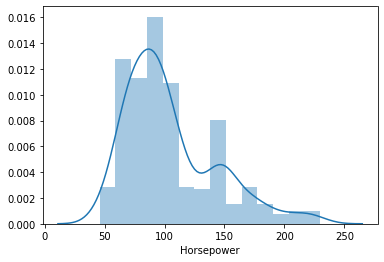

In [10]:
df["Horsepower"] = df["Horsepower"].fillna(df["Horsepower"].mean())
sns.distplot(df.Horsepower)

In [11]:
df.isna().sum()

target          0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

# Exploratory Data Analysis

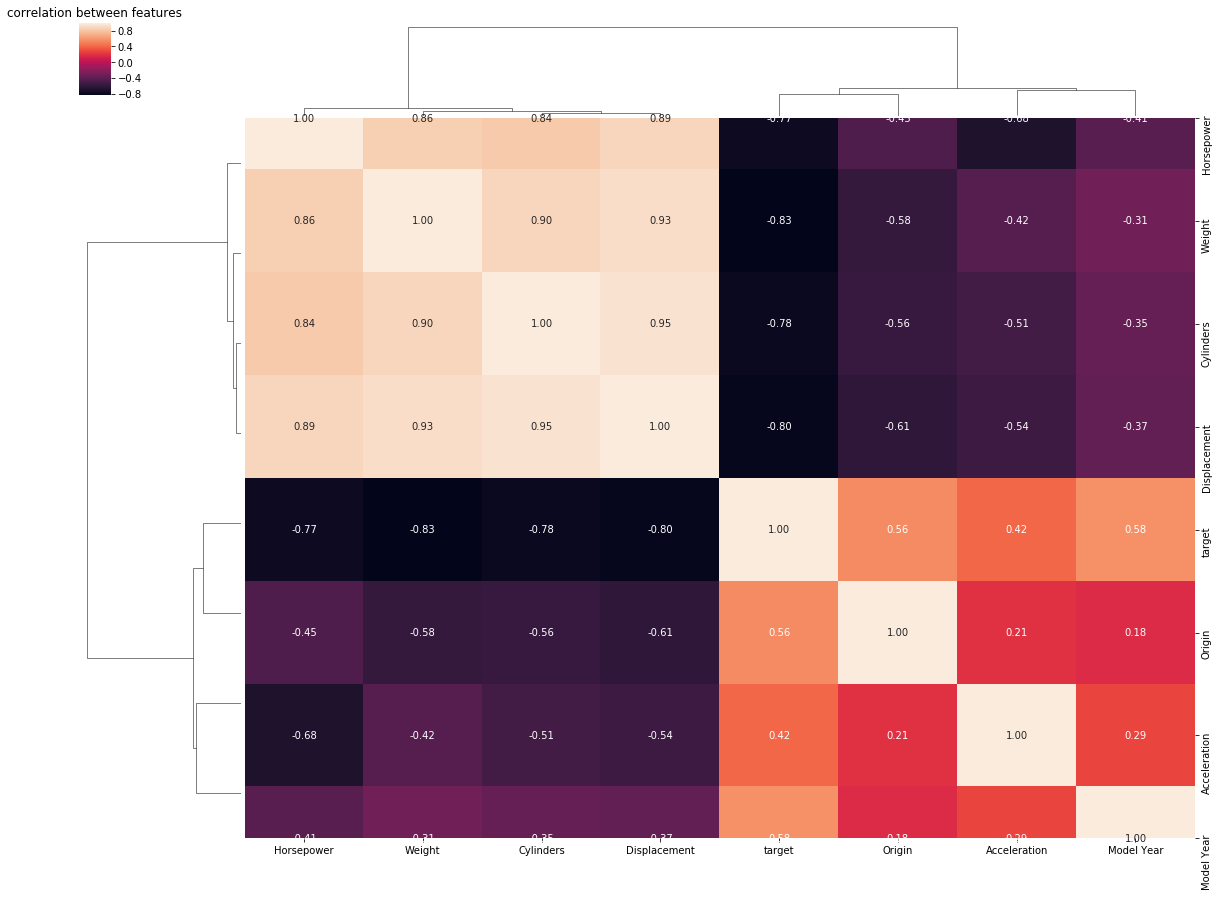

In [12]:
corr_matrix = df.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f", figsize=(20, 15))
plt.title("correlation between features")
plt.show()

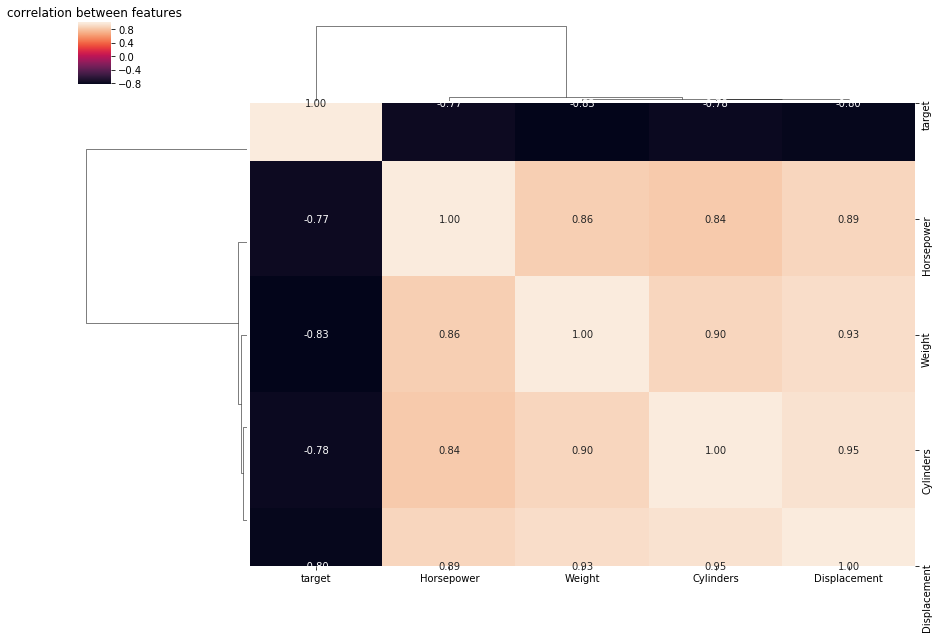

In [13]:
threshold = 0.75
filt = np.abs(corr_matrix["target"]) > threshold
corr_features = corr_matrix.columns[filt].tolist()
sns.clustermap(df[corr_features].corr(), annot = True, fmt = ".2f", figsize=(15, 10))
plt.title("correlation between features")
plt.show()

When we look at the graph, we can understand that there is a Multicollinearity.

Multicollinearity refers to a situation in which two or more explanatory variables in a multiple regression model are highly linearly related

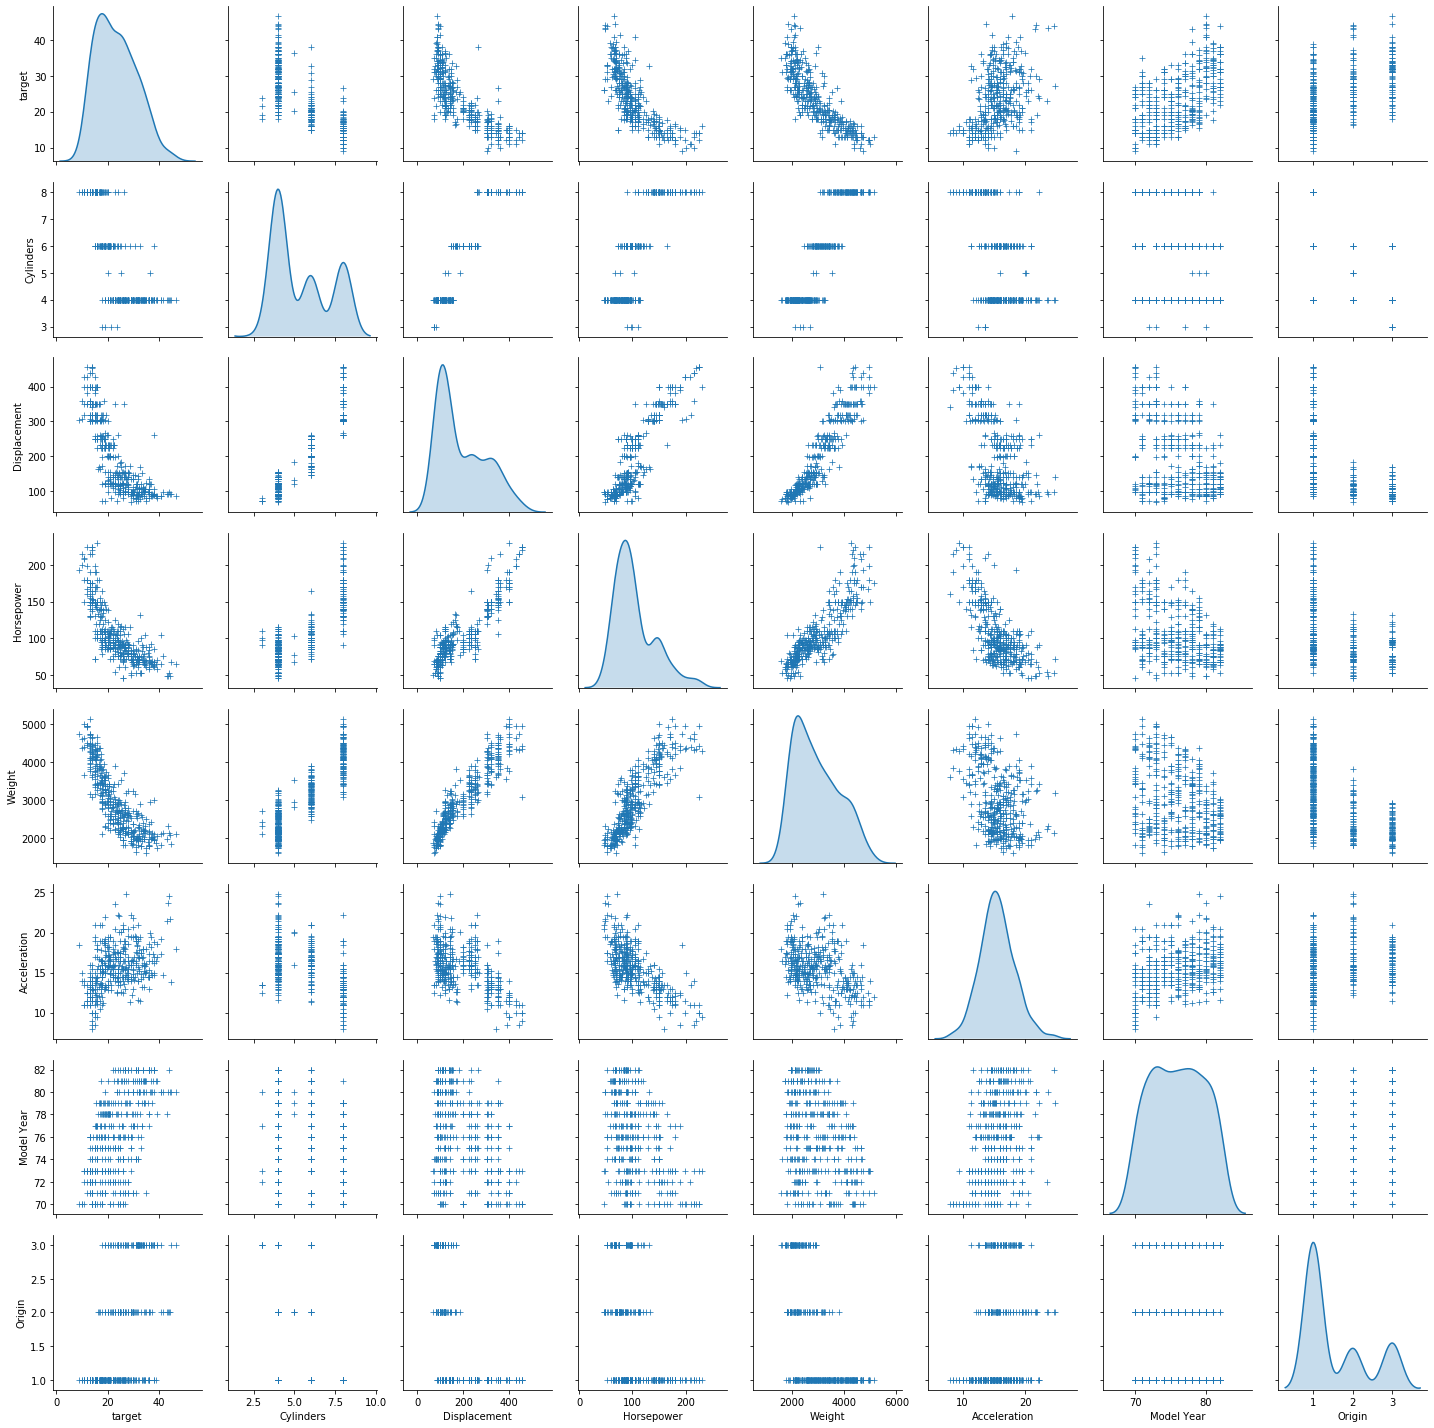

In [14]:
sns.pairplot(df, diag_kind= "kde", markers= "+")
plt.show()

Cylinder and Origin can consider a categorical.

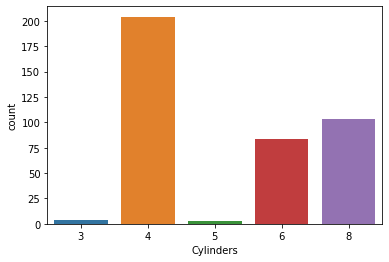

In [15]:
plt.figure()
sns.countplot(df["Cylinders"])

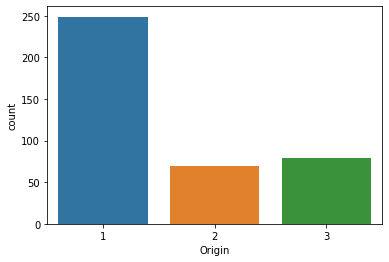

In [16]:
plt.figure()
sns.countplot(df["Origin"])

We can deal with them during the feature engineering phase.

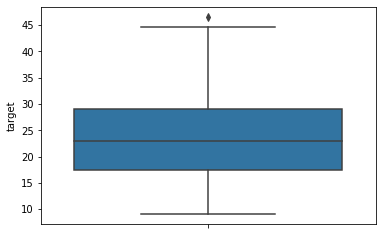

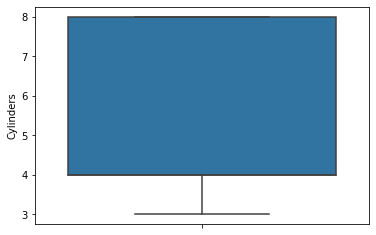

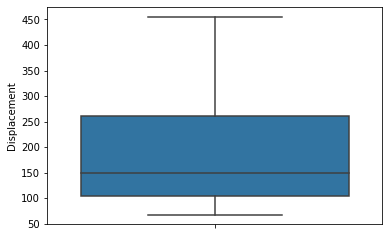

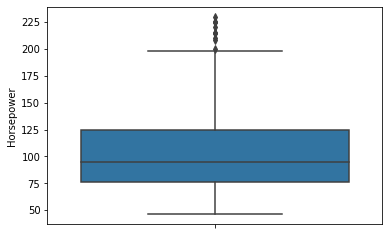

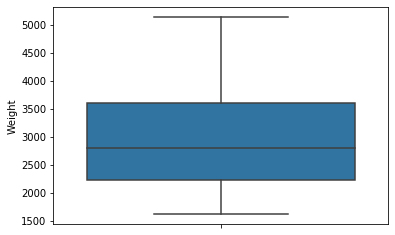

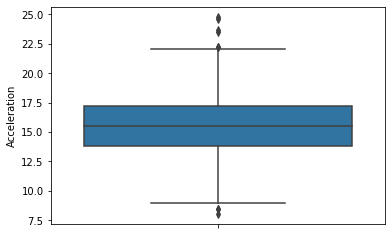

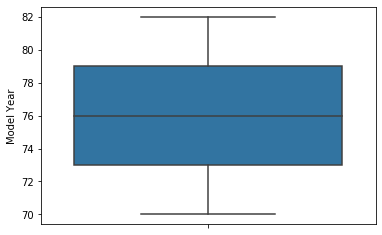

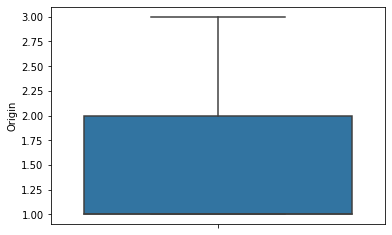

In [17]:
for c in df.columns:
    plt.figure()
    sns.boxplot(x = c, data = df, orient = "v")

We have outliers at Acceleration and Horsepower. We can deal with them during the outlier-drop phase.

### Outlier Detection and Drop

In [18]:
threshold = 2

horsepower_desc = df["Horsepower"].describe()
horsepower_desc

count    398.000000
mean     104.469388
std       38.199187
min       46.000000
25%       76.000000
50%       95.000000
75%      125.000000
max      230.000000
Name: Horsepower, dtype: float64

In [19]:
q1_hp = horsepower_desc[4]
q3_hp = horsepower_desc[6]
IQR_hp = q3_hp - q1_hp
top_limit_hp = q3_hp + threshold*IQR_hp
bot_limit_hp = q1_hp - threshold*IQR_hp
filter_hp_bot = bot_limit_hp < df["Horsepower"]
filter_hp_top = df["Horsepower"] < top_limit_hp
filter_hp = filter_hp_bot & filter_hp_top

df = df[filter_hp]

In [20]:
acceleration_desc = df["Acceleration"].describe()
acceleration_desc
q1_acc = acceleration_desc[4]
q3_acc = acceleration_desc[6]
IQR_acc = q3_acc - q1_acc
top_limit_acc = q3_acc + threshold*IQR_acc
bot_limit_acc = q1_acc - threshold*IQR_acc
filter_acc_bot = bot_limit_acc < df["Acceleration"]
filter_acc_top = df["Acceleration"] < top_limit_acc
filter_acc = filter_acc_bot & filter_acc_top

df = df[filter_acc]

### Feature Engineering

#### Skewness 

#### Target Dependent Variable

In [21]:
df["target"].describe()

count    391.000000
mean      23.499233
std        7.688438
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: target, dtype: float64

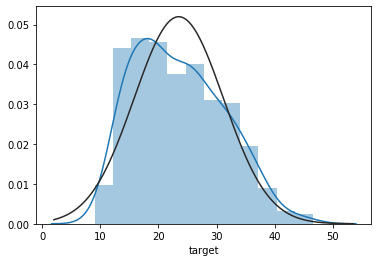

In [22]:
sns.distplot(df.target, fit = norm)

In [23]:
(mu, sigma) = norm.fit(df["target"])
print("mu : {}, sigma : {} ".format(mu,sigma))

mu : 23.499232736572893, sigma : 7.678599778082707 


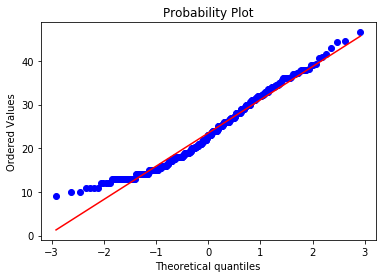

In [24]:
# qq plot
plt.figure()
stats.probplot(df["target"], plot = plt)
plt.show()

It does not have a normal distribution.

We will use log transform to reduce the skew value.

In [25]:
df["target"] = np.log1p(df["target"])

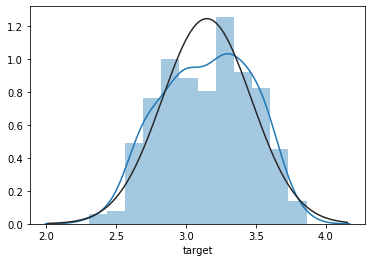

In [26]:
plt.figure()
sns.distplot(df.target, fit = norm)

We can see reducing skew value.

In [27]:
(mu, sigma) = norm.fit(df["target"])
print("mu : {}, sigma : {} ".format(mu,sigma))

mu : 3.148549778053243, sigma : 0.31986792768696354 


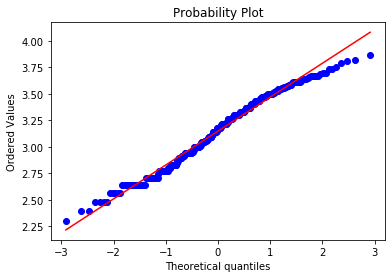

In [28]:
# qq plot
plt.figure()
stats.probplot(df["target"], plot = plt)
plt.show()

#### Feature: Independent Variable

In [29]:
skewed_feats = df.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame(skewed_feats, columns = ["skewed"])
skewness

,skewed
Horsepower,1.002620
Origin,0.915147
Displacement,0.692506
Cylinders,0.539419
Weight,0.530167
Acceleration,0.144566
Model Year,0.010762
target,-0.134213


Skewness > 1 == Positive Skewness

Skewness < -1 == Negative Skewness

#### One Hot Encoding

We are encoding numeric variables to categorical variables. (origin, cylinders)

In [30]:
df["Cylinders"] = df["Cylinders"].astype(str)
df["Origin"] = df["Origin"].astype(str)

df = pd.get_dummies(df)

In [31]:
df

,target,Displacement,Horsepower,Weight,Acceleration,Model Year,Cylinders_3,Cylinders_4,Cylinders_5,Cylinders_6,Cylinders_8,Origin_1,Origin_2,Origin_3
0,2.944439,307.0,130.0,3504.0,12.0,70,0,0,0,0,1,1,0,0
1,2.772589,350.0,165.0,3693.0,11.5,70,0,0,0,0,1,1,0,0
2,2.944439,318.0,150.0,3436.0,11.0,70,0,0,0,0,1,1,0,0
3,2.833213,304.0,150.0,3433.0,12.0,70,0,0,0,0,1,1,0,0
4,2.890372,302.0,140.0,3449.0,10.5,70,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,3.332205,151.0,90.0,2950.0,17.3,82,0,1,0,0,0,1,0,0
393,3.332205,140.0,86.0,2790.0,15.6,82,0,1,0,0,0,1,0,0
395,3.496508,135.0,84.0,2295.0,11.6,82,0,1,0,0,0,1,0,0
396,3.367296,120.0,79.0,2625.0,18.6,82,0,1,0,0,0,1,0,0


# Preprocess And Standardization

#### Split

In [32]:
x = df.drop(["target"], axis = 1)
y = df.target

In [33]:
test_size = 0.9

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = test_size, random_state = 42)

#### Standardization

In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Regression Models

## Linear Regression

In [36]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
print("LR Coef:",lr.coef_)

LR Coef: [-0.12110124 -0.04555804 -0.05953953 -0.0481553   0.09419335  0.
  0.00514635 -0.02470095  0.00237915  0.00674877 -0.01462858  0.02221117
 -0.00883751]


In [37]:
y_pred_dummy = lr.predict(X_test)
mse = mean_squared_error(Y_test, y_pred_dummy)
print("linear regression MSE: " , mse)

linear regression MSE:  0.017803776531038408


## Ridge Regression

Ridge Coef:  [-0.10285747 -0.04596053 -0.06532809 -0.04703368  0.09401689  0.
  0.01082148 -0.02307721 -0.00116098  0.00097552 -0.01534303  0.02275077
 -0.0084845 ]
----------------------------------------
Ridge Best Estimator:  Ridge(alpha=0.31622776601683794, copy_X=True, fit_intercept=True,
      max_iter=10000, normalize=False, random_state=42, solver='auto',
      tol=0.001)
----------------------------------------
Ridge MSE:  0.017051767371789484
----------------------------------------


Text(0.5, 1.0, 'Ridge')

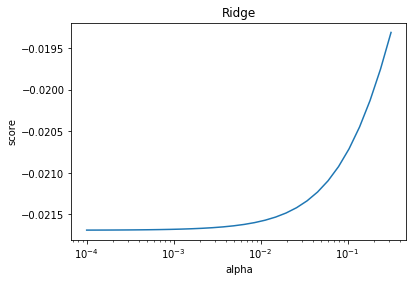

In [38]:
ridge = Ridge(random_state = 42, max_iter = 10000)
alphas = np.logspace(-4, -0.5, 30)

#gridsearch validation
tuned_parameters = [{"alpha": alphas}]
n_folds = 5

clf = GridSearchCV(ridge, tuned_parameters, cv = n_folds, scoring = "neg_mean_squared_error", refit = True)
clf.fit(X_train, Y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Ridge Coef: ", clf.best_estimator_.coef_)
print("----------------------------------------")

ridge = clf.best_estimator_

print("Ridge Best Estimator: ", ridge)
print("----------------------------------------")

y_pred_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test, y_pred_dummy)
print("Ridge MSE: ", mse)
print("----------------------------------------")

plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Ridge")

Using ridge regression, we have achieved success in mse, even if it is small.

## Lasso Regression

If we see "coef" values as 0 in lasso regression, we understand that it has no effect on our dependent variable.

Another advantage of lasso regression: If there is high correlation in our features, lasso uses only the most important of them.

Lasso Coef:  [-0.11896842 -0.         -0.08103413 -0.01166124  0.07100283  0.
  0.00304688 -0.         -0.         -0.         -0.          0.
  0.        ]
----------------------------------------
Lasso Best Estimator:  Lasso(alpha=0.0196382800192977, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------------------------
Lasso MSE:  0.016520105807564
----------------------------------------


Text(0.5, 1.0, 'Lasso')

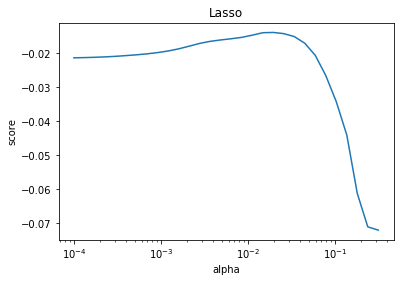

In [39]:
lasso = Lasso(random_state = 42, max_iter = 10000)
alphas = np.logspace(-4, -0.5, 30)

#gridsearch validation
tuned_parameters = [{"alpha": alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv = n_folds, scoring = "neg_mean_squared_error", refit = True)
clf.fit(X_train, Y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Lasso Coef: ", clf.best_estimator_.coef_)
print("----------------------------------------")

lasso = clf.best_estimator_

print("Lasso Best Estimator: ", lasso)
print("----------------------------------------")

y_pred_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test, y_pred_dummy)
print("Lasso MSE: ", mse)
print("----------------------------------------")

plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Lasso")

We have reached a better value in lasso regression as the "mse" value.

## ElasticNet

ElasticNet is a good method for highly correlated relationships.

In [40]:
parametersGrid = {"alpha": alphas,
                  "l1_ratio": np.arange(0.0, 1.0, 0.05)}

eNet = ElasticNet(random_state=42, max_iter=10000)
clf = GridSearchCV(eNet, parametersGrid, cv=n_folds, scoring='neg_mean_squared_error', refit=True)
clf.fit(X_train, Y_train)


print("ElasticNet Coef: ",clf.best_estimator_.coef_)
print("---------------------------------------")
print("ElasticNet Best Estimator: ",clf.best_estimator_)
print("---------------------------------------")


y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("ElasticNet MSE: ",mse)

ElasticNet Coef:  [-0.06677399 -0.03329352 -0.06777475 -0.03014659  0.07455473  0.
  0.0392998  -0.00073448 -0.         -0.01057325 -0.00872815  0.01347745
  0.        ]
---------------------------------------
ElasticNet Best Estimator:  ElasticNet(alpha=0.1373823795883264, copy_X=True, fit_intercept=True,
           l1_ratio=0.05, max_iter=10000, normalize=False, positive=False,
           precompute=False, random_state=42, selection='cyclic', tol=0.0001,
           warm_start=False)
---------------------------------------
ElasticNet MSE:  0.014937926405166658


## Evaluate Regression Models

In [42]:
print("Linear Regression MSE: 0.017803776531038408")
print("Ridge Regression MSE: 0.017051767371789484")
print("Lasso Regression MSE: 0.016520105807564")
print("ElasticNet MSE: 0.014937926405166658")

Linear Regression MSE: 0.017803776531038408
Ridge Regression MSE: 0.017051767371789484
Lasso Regression MSE: 0.016520105807564
ElasticNet MSE: 0.014937926405166658


These results belong to StandardScaler.

But if we use RobustScaler?

In [43]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

I rerun the same codes above and the results I got:

In [44]:
print("Linear Regression MSE: 0.01784753653196397")
print("Ridge Regression MSE: 0.01657369051216715")
print("Lasso Regression MSE: 0.016049583329796")
print("ElasticNet MSE: 0.01559554749905533")

Linear Regression MSE: 0.01784753653196397
Ridge Regression MSE: 0.01657369051216715
Lasso Regression MSE: 0.016049583329796
ElasticNet MSE: 0.01559554749905533


## XGBoost

In [46]:
parametersGrid = {'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,1000]}

model_xgb = xgb.XGBRegressor()

clf = GridSearchCV(model_xgb, parametersGrid, cv = n_folds, scoring='neg_mean_squared_error', refit=True, n_jobs = 5, verbose=True)

clf.fit(X_train, Y_train)
model_xgb = clf.best_estimator_

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("XGBRegressor MSE: ",mse)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:   18.1s finished


XGBRegressor MSE:  0.018636674065329966


# Averaging Models

In [47]:
class AveragingModels():
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)  


averaged_models = AveragingModels(models = (model_xgb, lasso))
averaged_models.fit(X_train, Y_train)

y_predicted_dummy = averaged_models.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("Averaged Models MSE: ",mse)


Averaged Models MSE:  0.016080580508199858
